# Analysis of projects 1 year later

In [1]:

import networkx as nx
import pickle
import matplotlib.pyplot as plt
from nxpd import draw
from IPython.display import display
import numpy as np
from ipysankeywidget import SankeyWidget
from scipy import stats
from collections import defaultdict
import seaborn as sns
from IPython.display import (
    Image
)
import base64

colors=["#35a8e0", "#05c100", "#ffd300",'#d8b69f', '#d1000a', "#7F7F7F00"]

In [2]:
# functions to calculate feature vectors

_eps = 10**(-10)

def get_features(A):
    """Feature grabber for DiNetSimile algorithm. Features used are

        1. In-Degree of node
        2. Out-Degree of node
        3. Clustering coefficient of node
        4. Average clustering coefficient of predecessors of node
        5. Average clustering coefficient of successors of node
        6. Average number of successors of succesors of node
        7. Average number of successors of predecessors of node
        8. Average number of predecessors of succesors of node
        9. Average number of predecessors of predecessors of node
        10. Number of edges in successor egonet of node
        11. Number of edges in predecessor egonet of node
        12. reciprocity of in/out edges of node
    
    Parameters
    ---------
    A : NumPy matrix
        Adjacency matrix of graph in question. Preferably a SciPy sparse matrix
        for large graphs.

    Returns
    -------
    feature_mat : NumPy array
        An n by 12 array of features, where n = A.shape[0]

    """
    try:
        G = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())
    except AttributeError:
        G = nx.from_numpy_matrix(A, create_using=nx.DiGraph())       
    n = len(G)

    #number of in/out neighbors
    neighbors_suc = [list(set(G.successors(i))-{i}) for i in range(n)]
    neighbors_pre = [list(set(G.predecessors(i))-{i}) for i in range(n)]
    d_vec_out = np.array([len(suc) for suc in neighbors_suc])
    d_vec_in = np.array([len(pre) for pre in neighbors_pre])

    # average in/out degree of neighbors (successors) (0 if node is isolated)
    neighbor_suc_deg_in = [d_vec_in[neighbors_suc[i]].sum()/d_vec_out[i]
                    if d_vec_out[i]>_eps else 0 for i in range(n)]
    neighbor_suc_deg_out = [d_vec_out[neighbors_suc[i]].sum()/d_vec_out[i]
                    if d_vec_out[i]>_eps else 0 for i in range(n)]

    # average in/out degree of neighbors (predecessors) (0 if node is isolated)
    neighbor_pre_deg_in = [d_vec_in[neighbors_pre[i]].sum()/d_vec_in[i]
                    if d_vec_in[i]>_eps else 0 for i in range(n)]
    neighbor_pre_deg_out = [d_vec_out[neighbors_pre[i]].sum()/d_vec_in[i]
                    if d_vec_in[i]>_eps else 0 for i in range(n)]

    #clustering coefficient for all nodes
    clust_vec = np.array(list(nx.clustering(G).values()))

    #average clustering coefficient for predecessors and successors
    neighbor_clust_pre = [clust_vec[neighbors_pre[i]].sum()/d_vec_in[i] 
                      if d_vec_in[i]>_eps else 0 for i in range(n)]
    neighbor_clust_suc = [clust_vec[neighbors_suc[i]].sum()/d_vec_out[i] 
                      if d_vec_out[i]>_eps else 0 for i in range(n)]


    # egonets predecessors and successors
    egonets_suc = [nx.ego_graph(G,i) for i in range(n)]
    egonets_pre = [nx.ego_graph(G.reverse(),i) for i in range(n)]

    # number of edges in egonet
    ego_size_suc = [D.size() for D in egonets_suc]
    ego_size_pre = [D.size() for D in egonets_pre]


    #reciprocity - selfloops are ignored and isolate notes are given reciprocity zeroo
    G.remove_edges_from(G.selfloop_edges())
    recipro_dict=nx.algorithms.reciprocity(G,  nodes=[node for node in G])
    recipro=[]
    for k,v in recipro_dict.items():
        if v==None:
            recipro.append(0.0)
        else:
            recipro.append(v)


    # use mat.T so that each node is a row (standard format)
    feature_mat = np.array([d_vec_in, d_vec_out, clust_vec, neighbor_suc_deg_in, neighbor_suc_deg_out,
                            neighbor_pre_deg_in, neighbor_pre_deg_out, neighbor_clust_pre, neighbor_clust_suc,
                            ego_size_pre, ego_size_suc, recipro]).T 

    return feature_mat




def aggregate_features(feature_mat,row_var=False,as_matrix=False):
    """Returns column-wise descriptive statistics of a feature matrix.

    Parameters
    ----------
    feature_mat : NumPy array
        Matrix on which statistics are to be calculated. Assumed to be formatted
        so each row is an observation (a node, in the case of NetSimile).

    row_var : Boolean, optional (default=False)
        If true, then each variable has it's own row, and statistics are
        computed along rows rather than columns.

    as_matrix : Boolean, optional (default=False)
        If true, then description is returned as matrix. Otherwise, it is
        flattened into a vector.

    Returns
    -------
    description : NumPy array
        Descriptive statistics of feature_mat

    Notes
    -----

    References
    ----------
    """
    axis = int(row_var) 
    description = np.array([feature_mat.mean(axis=axis),
                            np.median(feature_mat,axis=axis),
                            np.std(feature_mat,axis=axis),
                            stats.skew(feature_mat,axis=axis),
                            stats.kurtosis(feature_mat,axis=axis)])
    if not as_matrix:
        description = description.flatten()
    return description


In [3]:
# trained support vector machine model to classify project into one of the group types
svm=pickle.load(open('./data/svm_classifier.p', 'rb'))
# final cluster partition
partition_original=pickle.load(open("data/final_partition", "rb"))
networks_original=pickle.load(open("paperdata/networks8to20", "rb"))

def get_original_graph_by_id(_id):
    return next(nw for nw in networks_original if nw.graph['id']==_id)

#### Get graph data
scrape pull request data from ghtorrent database for all projects in the second reference time frame (2017-09-01 to 2018-03-01) one year later.
Construct pull request graphs and save them in the dictionary graphs_second_period_dict.

In [ ]:
import MySQLdb
# connect to ghtorrent db dump
db=MySQLdb.connect(
                 host="127.0.0.1", 
                 user="root", 
                 passwd="enterenter"
               )
cursor = db.cursor()
cursor.execute("use ghtorrent_restore")

graphs_second_period_dict = {}
for i,n_id in enumerate(list(partition_original.keys())):
    try: 
        sql_str="""
        select prh2.actor_id, prh1.actor_id
          from pull_requests pr, pull_request_history prh1, pull_request_history prh2
          where pr.base_repo_id = %s
            and prh1.pull_request_id = pr.id
            and prh2.pull_request_id = pr.id
            and prh1.action = 'opened'
            and prh2.action = 'merged'
            and prh2.created_at BETWEEN date('2017-09-01') AND date("2018-03-01")
        """%(n_id)


        cursor.execute(sql_str)
        #get all pull requests in the time period
        merge_pairs=cursor.fetchall()

        if len(merge_pairs) > 0:
            G = nx.DiGraph(id=n_id)

            for p in merge_pairs:
                if G.has_edge(p[1], p[0]):
                    # we added this edge before, so just increase the weight by one
                    G[p[1]][p[0]]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    G.add_edge(p[1], p[0], weight=1) 
            graphs_second_period_dict[n_id] = G
        else:
            graphs_second_period_dict[n_id] = None

    except:
        print("fail")
        print("project_id", n_id)
        pass



save/load network data from second period

In [ ]:
#pickle.dump(graphs_second_period_dict, open("networks_second_period.p", "wb"))
graphs_second_period_dict = pickle.load(open("networks_second_period.p", "rb"))

#### calculate feature vectors for each project

In [5]:
feature_vecs_later= {}
for key,net in graphs_second_period_dict.items():
    if net!=None:
        feat = get_features(nx.adjacency_matrix(net)) 
        aggr_feat= aggregate_features(feat)
        feature_vecs_later[key]=aggr_feat
    else:
        feature_vecs_later[key]=None
        



## Stability of cluster types
### How have group sizes changed?

In [32]:
trans_matrix_group_sizes=np.zeros((5, 5))
for key in partition_original: #still_8to20:
    old = partition_original[key]
    net = graphs_second_period_dict[key]
    if net==None or len(net)<3:
        new=0
    elif 3 <= len(net) < 8:
        new=1
    elif 8 <= len(net) < 21:
        new=2
    elif 21 <= len(net) <= 50:
        new=3
    elif 50 < len(net):
        new=4
    else:
        print(key)
    trans_matrix_group_sizes[old][new]+=1
    
row_sums = trans_matrix_group_sizes.sum(axis=1)
trans_matrix_group_sizes_normalized = trans_matrix_group_sizes / row_sums[:, np.newaxis]
print(trans_matrix_group_sizes_normalized)

[[0.35009488 0.29316888 0.30265655 0.04933586 0.00474383]
 [0.25642595 0.26070991 0.40636475 0.07405141 0.00244798]
 [0.33210332 0.34686347 0.2896679  0.02583026 0.00553506]
 [0.33206831 0.32447818 0.30170778 0.04174573 0.        ]
 [0.34545455 0.37662338 0.25454545 0.02337662 0.        ]]


In [13]:
links=[]

for i in range(5):
    for j in range(5):
        links.append({"source": "old 0", "target": "new "+str(j), "color": colors[i], "value": trans_matrix_group_sizes_normalized[i][j], "type": str(i)})
order = [
    [ ['old 0'], ['old 1'], ['old 2'], ['old 3'], ['old 4']],
    [ ['new 0'],  ['new 1'],  ['new 2'],  ['new 3'],  ['new 4']]
]

groups = [
    {'id': 'G', 'title': '09/16 -- 03/17', 'nodes': ['old 0']},
     {'id': 'G', 'title': '09/17 -- 03/18', 'nodes': ['new 0', 'new 1', "new 2", "new 3", "new 4"]}
]
nodes = [
    {'id': 'old 0', 'title': '8 to 20', 'style': 'process', "color": colors[0] },
    {'id': 'new 0', 'title': '< 3', 'style': 'process', "color": colors[0] },
    {'id': 'new 1', 'title': '3 to 7', 'style': 'process', "color": colors[1] },
    {'id': 'new 2', 'title': '8 to 20', 'style': 'process', "color": colors[2] },
    {'id': 'new 3', 'title': '21 to 50', 'style': 'process', "color": colors[3] },
    {'id': 'new 4', 'title': '> 50', 'style': 'process', "color": colors[4] }
]
sanky_transition_group_sizes= SankeyWidget(title="test", links=links, nodes=nodes, groups=groups, margins={"top": 30, "right": 110}, align_link_types=True)

In [14]:
sanky_transition_group_sizes

SankeyWidget(align_link_types=True, groups=[{'id': 'G', 'title': '09/16 -- 03/17', 'nodes': ['old 0']}, {'id':…

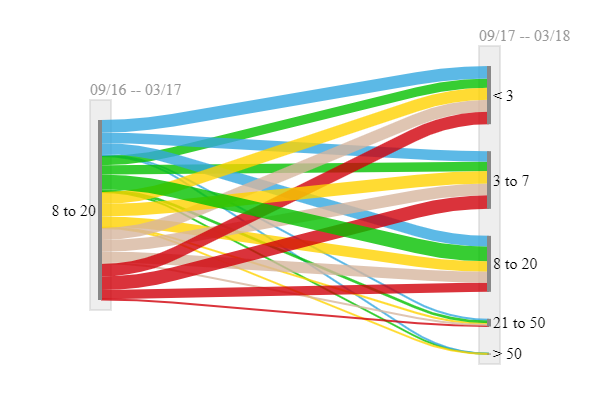

In [15]:
data = base64.decodebytes(bytes(sanky_transition_group_sizes.png, 'ascii'))
Image(data)

### How have group types changed?
We found that the classifier only reliably classifies projects that have more that 7 members, since the data it was trained on was groups with at least 7 members.

In [124]:
trans_matrix_cluster_type = np.zeros((5, 6))
partition_new = {}
fail=0
for key in partition_original: #still_8to20:
    old = partition_original[key]
    new_net = graphs_second_period_dict[key]
    if new_net==None or len(new_net)<8:
        trans_matrix_cluster_type[old][5]+=1
        fail+=1
    else:      
        new = svm.predict([feature_vecs_later[key]])[0]
        trans_matrix_cluster_type[old][new]+=1
        partition_new[key]=new
print(fail, " projects have less than 8 group members")
row_sums = trans_matrix_cluster_type.sum(axis=1)
trans_matrix_cluster_type_normalized = trans_matrix_cluster_type / row_sums[:, np.newaxis]


3193  projects have less than 8 group members


#### sanity check, wether the classified projects make sense

cluster 1


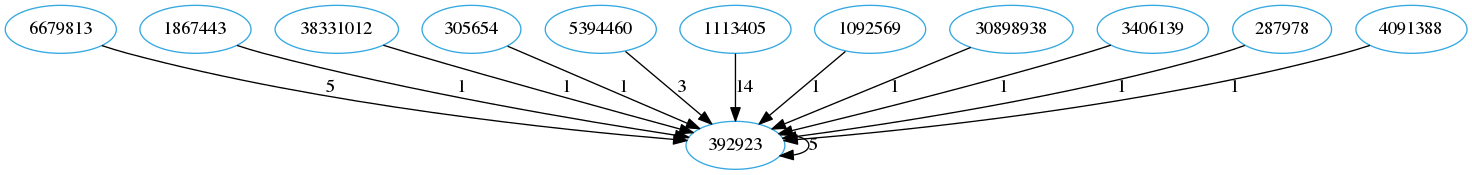

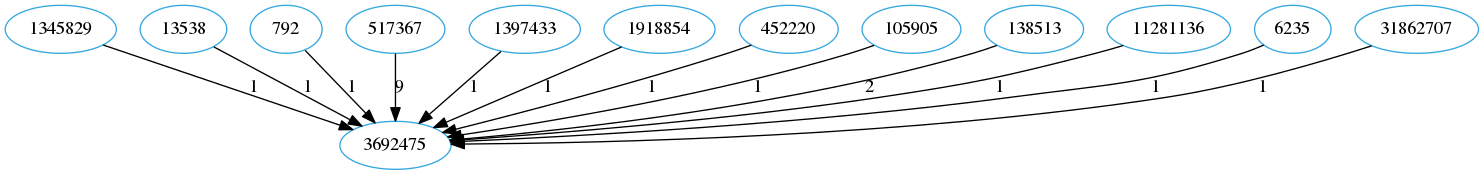

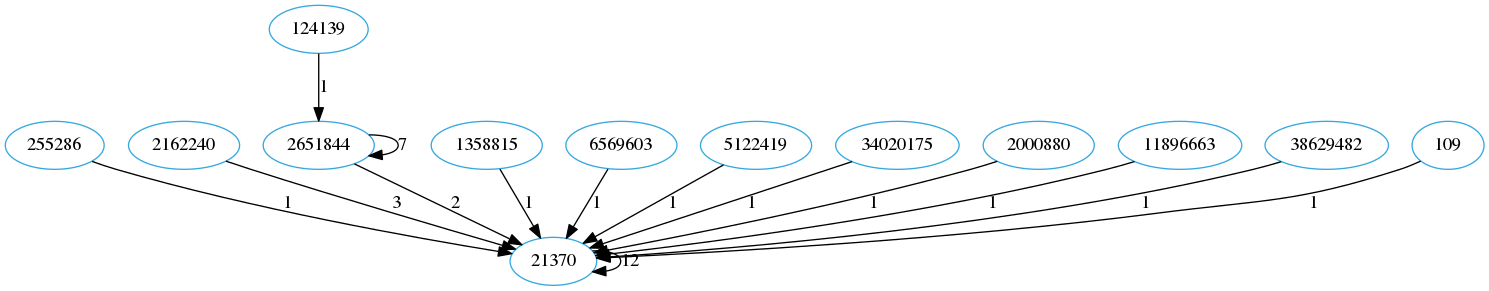

cluster 2


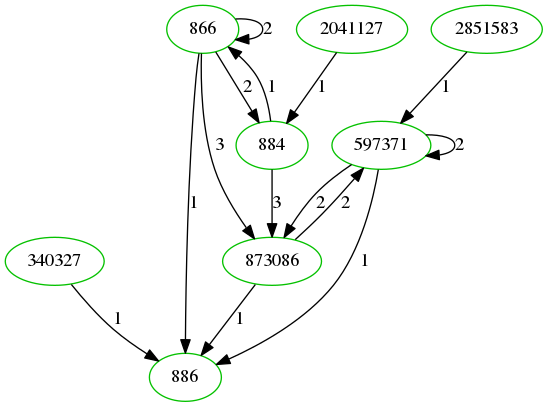

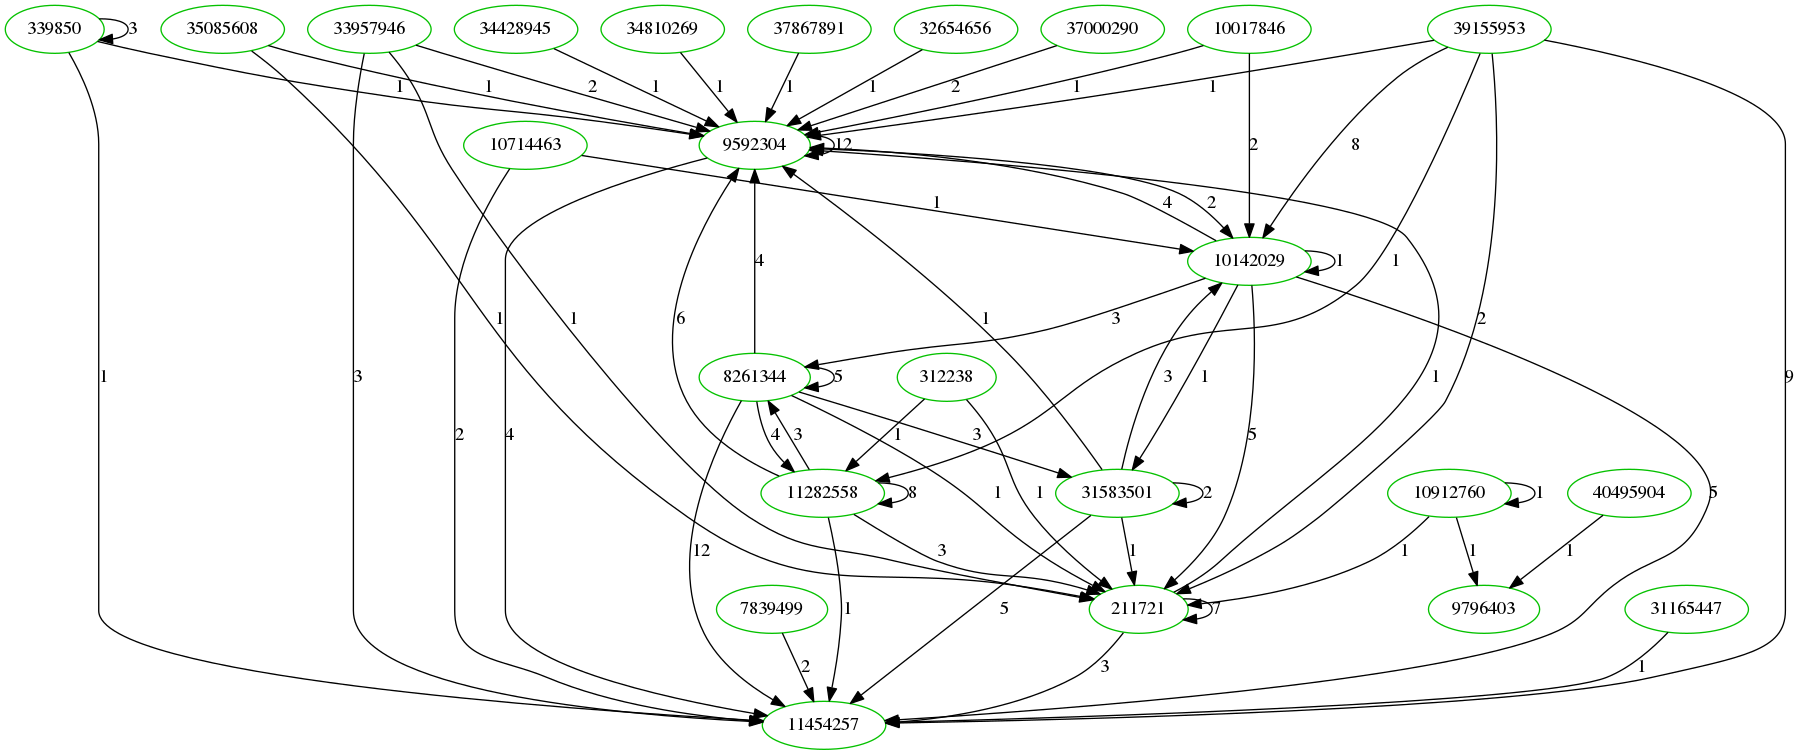

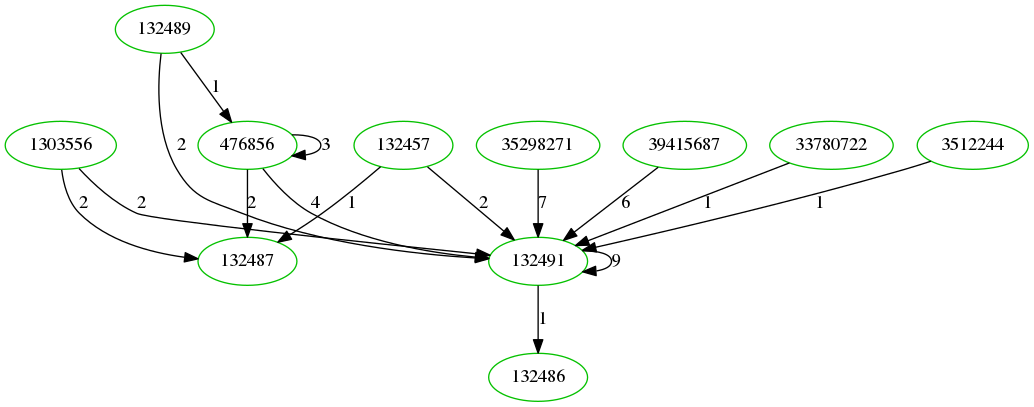

cluster 3


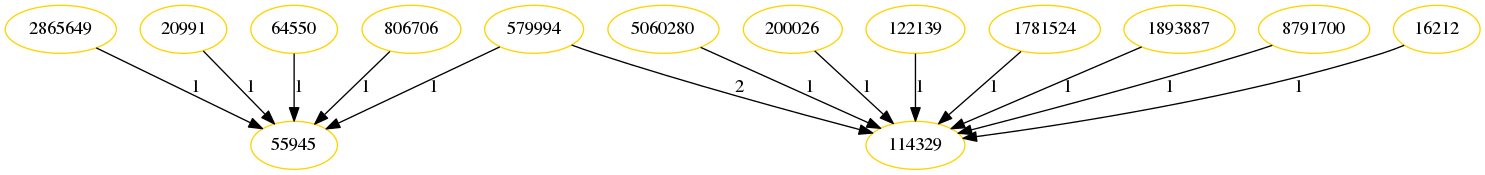

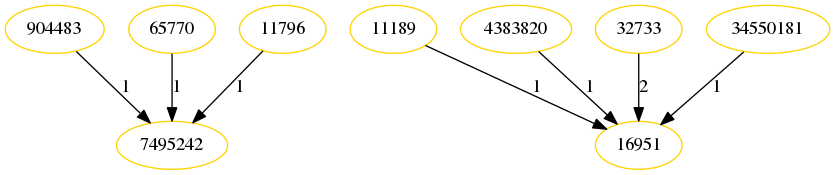

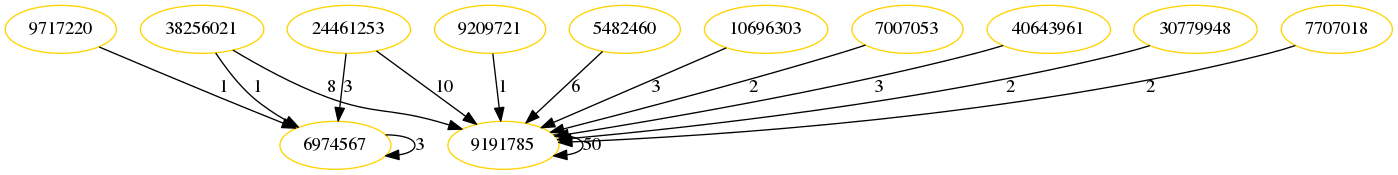

cluster 4


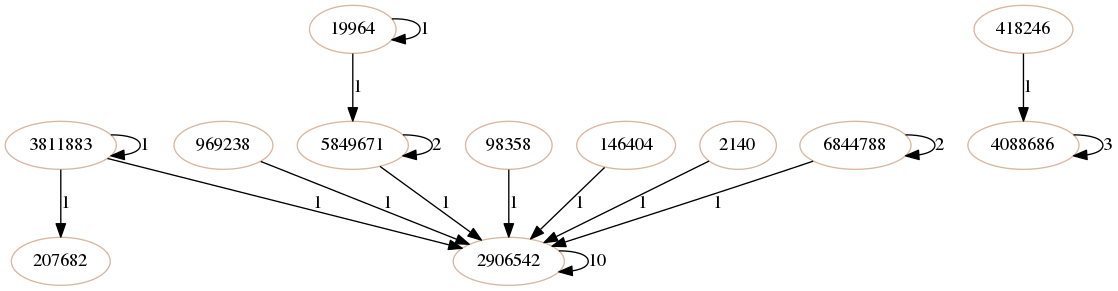

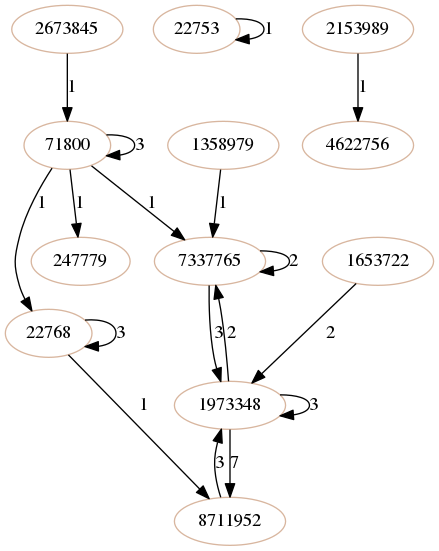

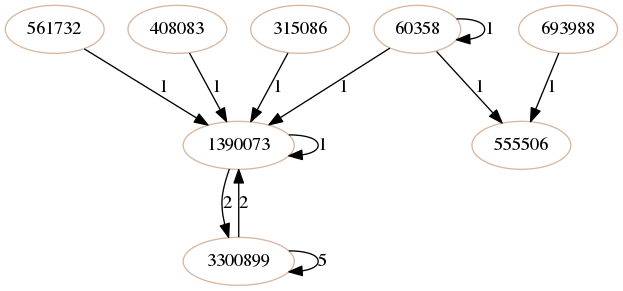

cluster 5


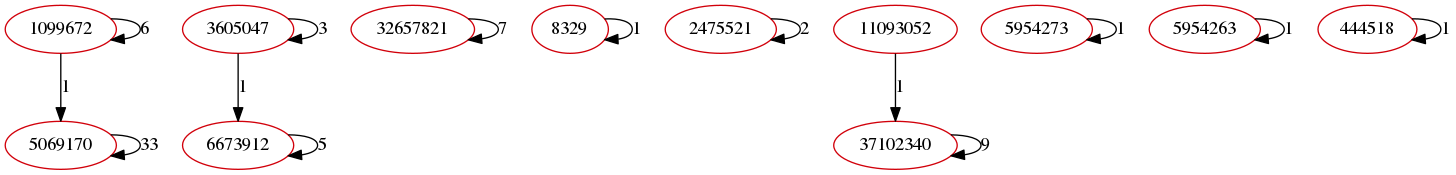

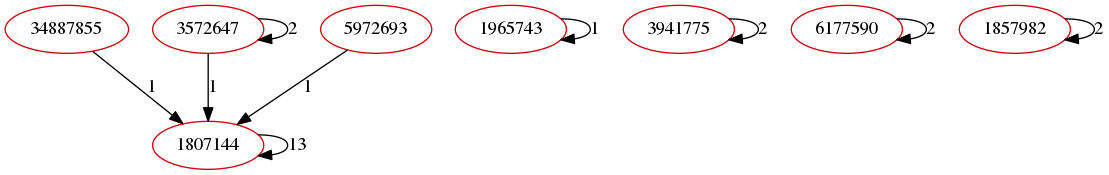

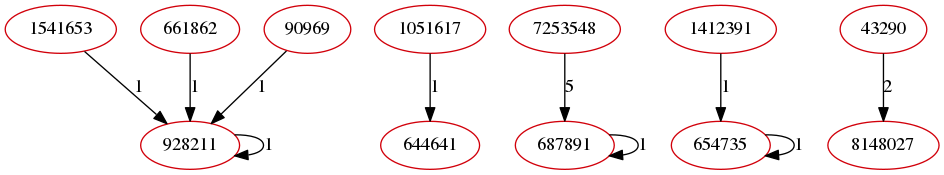

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

<Figure size 720x144 with 0 Axes>

In [128]:
from nxpd import draw
def draw_new_project(_id,node_color="black"):
    testnw=graphs_second_period_dict[_id]
    nx.set_node_attributes(testnw, node_color ,'color')
    for pairs in testnw.adjacency():
        for edge in pairs[1]:   
            testnw[pairs[0]][edge]['label']=str(pairs[1][edge]['weight'])
    

    fig=plt.figure(figsize=(10,2))
    
    return draw(testnw, show='ipynb')

print("cluster 1")
newcluster1=[x for x in partition_new if partition_new[x]==0]
for project in np.random.choice(newcluster1, 3):
    display(draw_new_project(project, node_color=colors[0]))
    
print("cluster 2") 
newcluster2=[x for x in partition_new if partition_new[x]==1]
for project in np.random.choice(newcluster2, 3):
    display(draw_new_project(project, node_color=colors[1]))

print("cluster 3") 
newcluster3=[x for x in partition_new if partition_new[x]==2]
for project in np.random.choice(newcluster3, 3):
    display(draw_new_project(project, node_color=colors[2]))

print("cluster 4")
newcluster4=[x for x in partition_new if partition_new[x]==3]
for project in np.random.choice(newcluster4, 3):
    display(draw_new_project(project, node_color=colors[3]))
    
print("cluster 5")    
newcluster5=[x for x in partition_new if partition_new[x]==4]
for project in np.random.choice(newcluster5, 3):
    display(draw_new_project(project, node_color=colors[4]))
    

#### plot transition matrix for cluster types

In [130]:

links=[]
for i in range(5):
    for j in range(6):
        if j==5:
            # add opacity to projects that have too < 3 group members
             links.append({"source": "old "+str(i), "target": "new "+str(j), "color": colors[i] + "55", "value": trans_matrix_cluster_type_normalized[i][j]})
        else:
            links.append({"source": "old "+str(i), "target": "new "+str(j), "color": colors[i], "value": trans_matrix_cluster_type_normalized[i][j]})
                   
order = [
    [ ['old 0'], ['old 1'], ['old 2'], ['old 3'], ['old 4'], []],
    [ ['new 0'],  ['new 1'],  ['new 2'],  ['new 3'],  ['new 4'],  ['new 5']]
]


groups = [
    {'id': 'G', 'title': '09/16 -- 03/17', 'nodes': ['old 0', 'old 1', "old 2", "old 3", "old 4"]},
     {'id': 'G', 'title': '09/17 -- 03/18', 'nodes': ['new 0', 'new 1', "new 2", "new 3", "new 4", "new 5"]}
]
nodes = [
    {'id': 'old 0', 'title': 'Cl. 1', 'style': 'process', "color": colors[0] },
    {'id': 'old 1', 'title': 'Cl. 2', 'style': 'process', "color": colors[1] },
    {'id': 'old 2', 'title': 'Cl. 3', 'style': 'process', "color": colors[2] },
    {'id': 'old 3', 'title': 'Cl. 4', 'style': 'process', "color": colors[3] },
    {'id': 'old 4', 'title': 'Cl. 5', 'style': 'process', "color": colors[4] },
    {'id': 'new 0', 'title': 'Cl. 1', 'style': 'process', "color": colors[0] },
    {'id': 'new 1', 'title': 'Cl. 2', 'style': 'process', "color": colors[1] },
    {'id': 'new 2', 'title': 'Cl. 3', 'style': 'process', "color": colors[2] },
    {'id': 'new 3', 'title': 'Cl. 4', 'style': 'process', "color": colors[3] },
    {'id': 'new 4', 'title': 'Cl. 5', 'style': 'process', "color": colors[4] },
    {'id': 'new 5', 'title': '< 8 members', 'style': 'process', "color": colors[5] }
]
sanky_transition_cluster_type = SankeyWidget(links=links, order=order, groups=groups , nodes=nodes, margins={"top": 30, "right": 110})


In [164]:
print(trans_matrix_cluster_type_normalized)

[[0.2329222  0.07827324 0.02656546 0.0170778  0.00189753 0.64326376]
 [0.05263158 0.33047736 0.02998776 0.04895961 0.02080783 0.51713586]
 [0.0904059  0.08856089 0.08856089 0.0295203  0.02398524 0.67896679]
 [0.03795066 0.10246679 0.06072106 0.09487666 0.04743833 0.65654649]
 [0.02337662 0.05194805 0.01818182 0.05194805 0.13246753 0.72207792]]


In [131]:
sanky_transition_cluster_type

SankeyWidget(groups=[{'id': 'G', 'title': '09/16 -- 03/17', 'nodes': ['old 0', 'old 1', 'old 2', 'old 3', 'old…

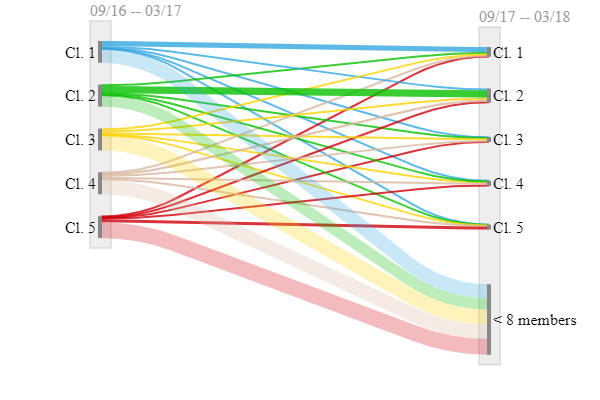

In [132]:
Image(base64.decodebytes(bytes(sanky_transition_cluster_type.png, 'ascii')))

We also want to plot the sanky diagram only for the projects that still had at least 8 members in the reference time period 1 year later.

In [158]:
trans_matrix_cluster_type_morethan7members = trans_matrix_cluster_type[:,:5]
row_sums = trans_matrix_cluster_type_morethan7members.sum(axis=1)
trans_matrix_cluster_type_morethan7members_normalized = trans_matrix_cluster_type_morethan7members / row_sums[:, np.newaxis]
trans_matrix_cluster_type_morethan7members_normalized

array([[0.65292553, 0.21941489, 0.07446809, 0.04787234, 0.00531915],
       [0.10899873, 0.68441065, 0.06210393, 0.10139417, 0.04309252],
       [0.2816092 , 0.27586207, 0.27586207, 0.09195402, 0.07471264],
       [0.11049724, 0.29834254, 0.17679558, 0.27624309, 0.13812155],
       [0.08411215, 0.18691589, 0.06542056, 0.18691589, 0.47663551]])

In [159]:

links=[]
for i in range(5):
    for j in range(5):
        links.append({"source": "old "+str(i), "target": "new "+str(j), "color": colors[i], "value": trans_matrix_cluster_type_morethan7members_normalized[i][j]})
                   
order = [
    [ ['old 0'], ['old 1'], ['old 2'], ['old 3'], ['old 4'], []],
    [ ['new 0'],  ['new 1'],  ['new 2'],  ['new 3'],  ['new 4']]
]


groups = [
    {'id': 'G', 'title': '09/16 -- 03/17', 'nodes': ['old 0', 'old 1', "old 2", "old 3", "old 4"]},
     {'id': 'G', 'title': '09/17 -- 03/18', 'nodes': ['new 0', 'new 1', "new 2", "new 3", "new 4"]}
]
nodes = [
    {'id': 'old 0', 'title': 'Cl. 1', 'style': 'process', "color": colors[0] },
    {'id': 'old 1', 'title': 'Cl. 2', 'style': 'process', "color": colors[1] },
    {'id': 'old 2', 'title': 'Cl. 3', 'style': 'process', "color": colors[2] },
    {'id': 'old 3', 'title': 'Cl. 4', 'style': 'process', "color": colors[3] },
    {'id': 'old 4', 'title': 'Cl. 5', 'style': 'process', "color": colors[4] },
    {'id': 'new 0', 'title': 'Cl. 1', 'style': 'process', "color": colors[0] },
    {'id': 'new 1', 'title': 'Cl. 2', 'style': 'process', "color": colors[1] },
    {'id': 'new 2', 'title': 'Cl. 3', 'style': 'process', "color": colors[2] },
    {'id': 'new 3', 'title': 'Cl. 4', 'style': 'process', "color": colors[3] },
    {'id': 'new 4', 'title': 'Cl. 5', 'style': 'process', "color": colors[4] } 
]
sanky_transition_cluster_type_morethan7mem = SankeyWidget(links=links, order=order, groups=groups , nodes=nodes, margins={"top": 30, "right": 110})


In [160]:
sanky_transition_cluster_type_morethan7mem

SankeyWidget(groups=[{'id': 'G', 'title': '09/16 -- 03/17', 'nodes': ['old 0', 'old 1', 'old 2', 'old 3', 'old…

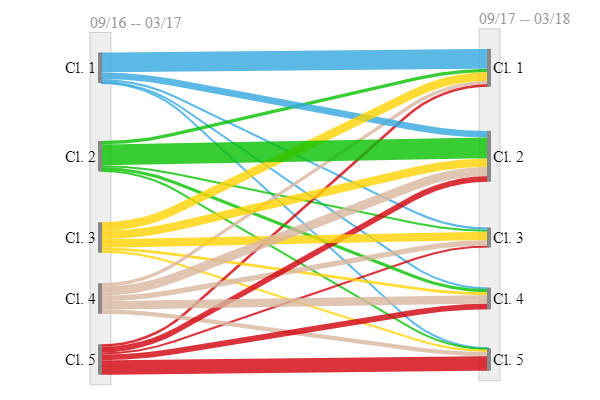

In [161]:
Image(base64.decodebytes(bytes(sanky_transition_cluster_type_morethan7mem.png, 'ascii')))

# Stability of group members

### fraction of group members that still contributed 1 year later

In [26]:
still_contributing=defaultdict(list)

for k,v in partition_original.items():
    if graphs_second_period_dict[k]!=None:
        set_original = set(get_original_graph_by_id(k).nodes)
        set_later_period = set(graphs_second_period_dict[k].nodes)
        ratio = len(set_original.intersection(set_later_period))/len(set_original)
        still_contributing[v].append(ratio)
        
    else:
         still_contributing[v].append(0.0)



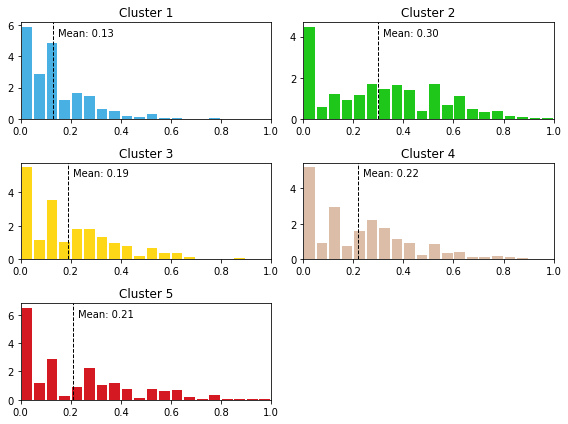

In [27]:
plt.figure(figsize=(8,6))
for k,v in still_contributing.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k+1), fontsize=12)
    sns.distplot(v, bins=[x/20 for x in range(21)], hist=True, color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean + 0.02, 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    #plt.yscale('log', nonposy='clip')
    #plt.xscale('log') 
    plt.xlim(0, 1) 
plt.tight_layout()

plt.show()

### number of pull requests one year later

In [133]:
prs_later_period=defaultdict(list)

for k,v in partition_original.items():
    if graphs_second_period_dict[k]!=None:
        later_net = graphs_second_period_dict[k]
        all_prs = later_net.size(weight="weight")
        prs_later_period[v].append(all_prs)
    else:
        prs_later_period[v].append(0.0)
        



plot distributions for each cluster

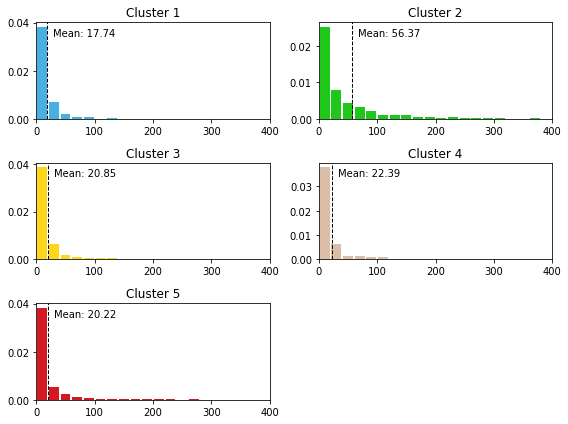

In [162]:
plt.figure(figsize=(8,6))
for k,v in prs_later_period.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k+1), fontsize=12)
    sns.distplot(v, bins=[x for x in range(0,400,20)], hist=True, color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean + 10, max_ - max_/7, 'Mean: {:.2f}'.format(vmean))
    plt.xlim(0, 400) 
plt.tight_layout()

plt.show()

### Ratio of all pull requests one year later that were submitted by old members

In [ ]:
ratio_prs_by_old_members=defaultdict(list)

for k,v in partition_original.items():
    if graphs_second_period_dict[k]!=None:
        original_contributors = get_original_graph_by_id(k).nodes
        later_net = graphs_second_period_dict[k]
        all_prs = later_net.size(weight="weight")
        prs_by_old_members = 0
        for edge in later_net.edges.data():
            submitter = edge[0]
            if submitter in original_contributors:
                prs_by_old_members += edge[2]['weight']
        ratio_prs_by_old_members[v].append(prs_by_old_members/all_prs)




plot distributions for each cluster

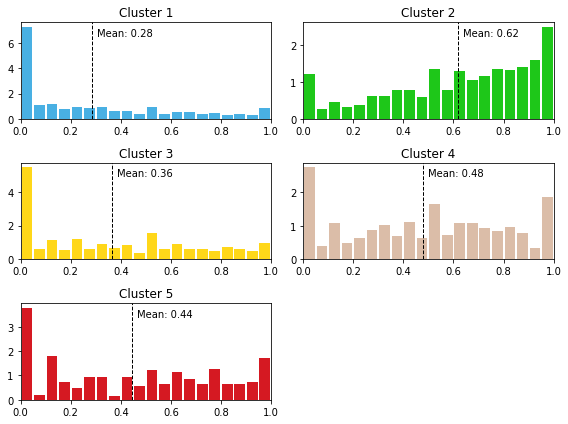

In [30]:
plt.figure(figsize=(8,6))
for k,v in ratio_prs_by_old_members.items():
    varr=np.array(v)
    vmean=varr.mean()
    plt.subplot(3,2,k+1)
    plt.title("Cluster " + str(k+1), fontsize=12)
    sns.distplot(v, bins=[x/20 for x in range(21)], hist=True, color=colors[k],hist_kws={"rwidth":0.85, "alpha":0.9}, kde=False, norm_hist=True)
    plt.axvline(vmean, color='k', linestyle='dashed', linewidth=1)
    _, max_ = plt.ylim()
    plt.text(vmean + 0.02, 
             max_ - max_/7, 
             'Mean: {:.2f}'.format(vmean))
    plt.xlim(0, 1) 
plt.tight_layout()

plt.show()